In [1]:
from trees_emulator.load_data import *
from trees_emulator.predicting import *
import numpy as np
import pickle
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

# Load Data

In [3]:
# Load Data
data = LoadData(2016, site="MHD", verbose=True)

Loading Meteorology data from data/met/EUROPE*10magl*2016*.nc
Loading footprint data from data/fps/MHD-10magl*2016*.nc
Cutting data to size
Loading extra meteorology from data/met/EUROPE*verticalgradients*2016*.nc and extracting gradients
Extracting wind vectors
All data loaded


In [4]:
# Load trained model. Info is a dict with general info about the training, clfs is a list of length size**2 with all regressors
with open('trained_models/MHD.txt', 'rb') as f:
    [info, clfs] = pickle.load(f)
print("Trained model info:", info)
print("Regressor parameters:", clfs[0])

Trained model info: {'site': 'MHD', 'training data': '201[4-5]', 'sampling frequency': 2, 'size': 10}
Regressor parameters: GradientBoostingRegressor(loss='absolute_error', max_depth=50,
                          max_features='sqrt', n_estimators=150)


In [5]:
# Set up inputs variables
## variables that are passed at the time of the footprint and x hours before
vars_with_past = [data.y_wind, data.x_wind, data.met.PBLH.values]
hours_before = 6
## variables that are only passed at the time of the footprint
vars_without_past = [data.temp_grad, data.x_wind_grad, data.y_wind_grad]

inputs = get_all_inputs(vars_with_past, 6, vars_without_past)

In [6]:
# Load the fluxes. Here fluxes are EDGARv6 regridded using a 2D mass-conservative regridding function, acrg.grid.regrid.regrid2d 
# (https://github.com/ACRG-Bristol/acrg/blob/develop/acrg/grid/regrid.py)
fluxes_og = xr.open_dataset("data/fluxes/ch4_EUROPE_2016_EDGARv6_regridded.nc")
fluxes = fluxes_og.sel(lat=data.fp_lats, lon= data.fp_lons, method="nearest")
fluxes = fluxes.flux.values

# Predict and plot

In [7]:
# Make predictions using the trained model and the new data 
## MakePredictions is a class that contains the real and emulated footprints under 
## predictions.truths and predictions.predictions, of shape (n_footprints, n_regressors each)
predictions = MakePredictions(clfs, data, inputs, hours_before)
true_flux, pred_flux = predictions.predict_fluxes(fluxes)

In [8]:
# Save the predictions
predictions.save_predictions(info)

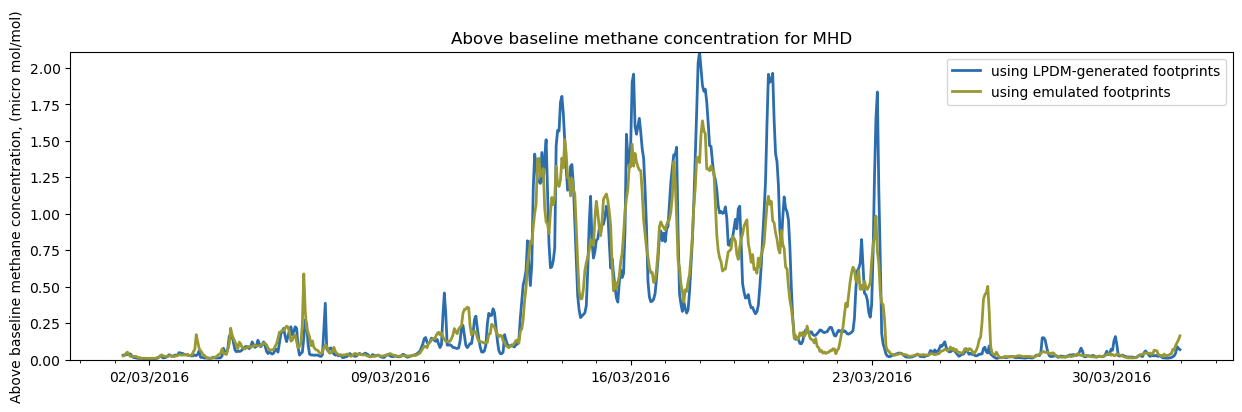

In [8]:
# Plot above baseline mole fraction for a particular month
month = 3 # March
predictions.plot_flux(month)

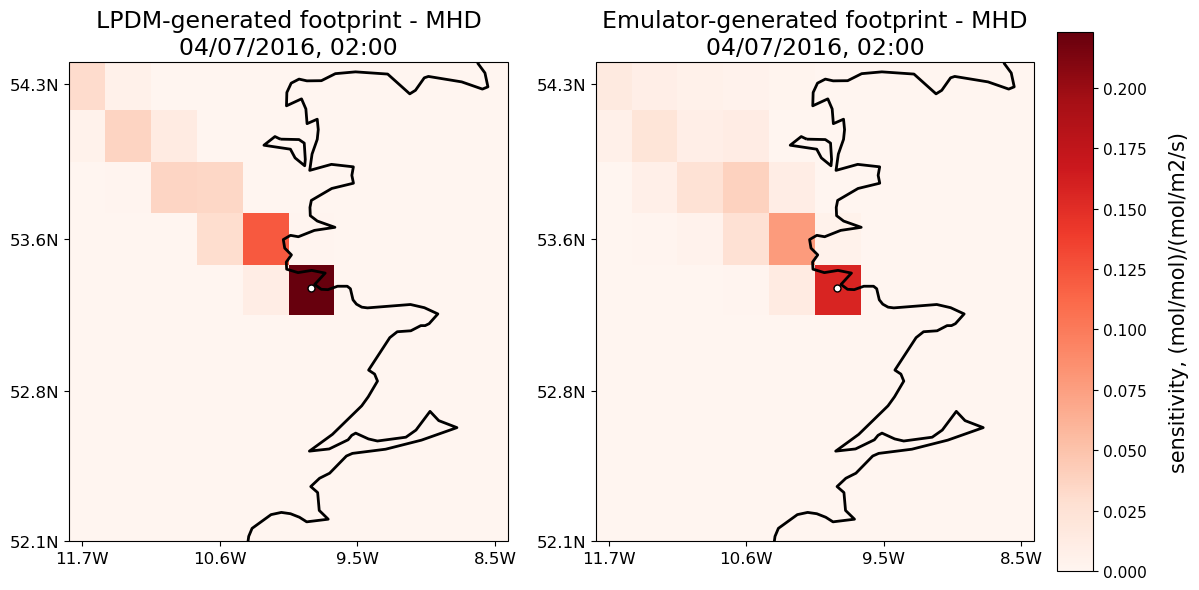

In [9]:
# Plot the real and emulated footprint for a particular date
t = "2:00 7/4/2016"
predictions.plot_footprint(t)

In [10]:
# t can also be an int, which will plot the footprints at that index. this allows for an iteration (run twice to start plotting)
try:
    predictions.plot_footprint(it)
    it+=3
except:
    it=0
    print("initialising")

initialising


In [ ]:
# Or the figure above can be saved as a gif for a range of dates
predictions.make_footprint_gif("0:00 7/4/2016", "0:00 17/4/2016")

Visualise gif: ![SegmentLocal](footprints_00-07-04-2016_00-17-04-2016.gif "segment")

# Evaluate

In [13]:
# Evaluate using metrics in paper
metrics = {"footprint NMAE":predictions.NMAE_fp(), "Above Threshold Accuracy with b=0":predictions.above_threshold_acc(threshold=0), "Above Threshold Accuracy with b=0.01":predictions.above_threshold_acc(threshold=0.01), "Flux NMAE":predictions.NMAE_flux(), "R2":predictions.R_squared(), "bias":predictions.bias()}
for name in metrics.keys():
    print(name, metrics[name])

footprint NMAE 0.6151408
Above Threshold Accuracy with b=0 63.51683848797251
Above Threshold Accuracy with b=0.01 91.5319587628866
Flux NMAE 0.33470439497715226
R2 0.7851846804005228
bias -2.417512820888234e-08


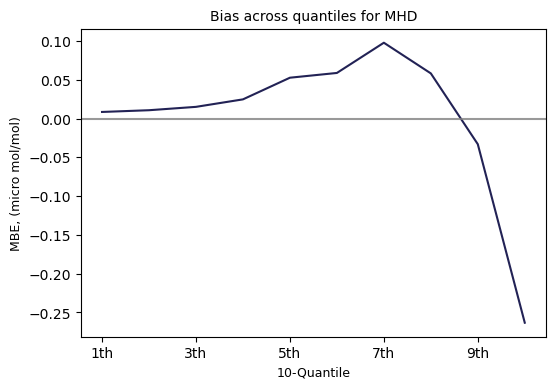

In [13]:
predictions.plot_bias(quantiles=10)